In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, classification_report, confusion_matrix
import seaborn as sns

In [62]:
df = pd.read_csv('/Users/billqiu/bootcamp_Zhiang_Qiu/project/data/raw/api_source-alpha_symbol-MSFT_20250820-142556.csv')

In [63]:
df.info(), df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       100 non-null    object 
 1   adj_close  100 non-null    float64
dtypes: float64(1), object(1)
memory usage: 1.7+ KB


(None,
 date         0
 adj_close    0
 dtype: int64)

In [64]:
df.describe()

,adj_close
count,100.0000
mean,460.0438
std,52.9538
min,354.5600
25%,431.3325
50%,470.6500
75%,505.3575
max,535.6400


In [65]:
df['ret'] = df['adj_close'].pct_change().fillna(0.0)
df['log_ret'] = np.log1p(df['ret'])
df.head()

,date,adj_close,ret,log_ret
0,2025-03-27,390.58,0.000000,0.000000
1,2025-03-28,378.80,-0.030160,-0.030624
2,2025-03-31,375.39,-0.009002,-0.009043
3,2025-04-01,382.19,0.018114,0.017952
4,2025-04-02,382.14,-0.000131,-0.000131


In [66]:
# Rolling 5-day and 20-day moving averages are both important indicators that can be used for trend following strategies
df['ma_5'] = df['adj_close'].rolling(5).mean()
df['ma_20'] = df['adj_close'].rolling(20).mean()
# Momentum: An important indicator for momentum based strategies
df['momentum_week'] = df['adj_close'] - df['adj_close'].shift(5)
# Volatility: A measure of risk
df['volatility'] = df['ret'].rolling(21).std()

In [67]:
# RSI feature
rsi_window = 14
delta = df['log_ret']
gain = np.where(delta > 0, delta, 0)
loss = np.where(delta < 0, -delta, 0)

avg_gain = pd.Series(gain).rolling(rsi_window, min_periods=rsi_window).mean()
avg_loss = pd.Series(loss).rolling(rsi_window, min_periods=rsi_window).mean()

rs = avg_gain / avg_loss
df.loc[:, "rsi"] = 100 - (100 / (1 + rs))

In [68]:
# MACD feature
macd_short, macd_long, macd_signal = 12, 26, 9
exp1 = df['adj_close'].ewm(span=macd_short, adjust=False).mean()
exp2 = df['adj_close'].ewm(span=macd_long, adjust=False).mean()
df.loc[:, "macd"] = exp1 - exp2
df.loc[:, "macd_signal"] = df["macd"].ewm(span=macd_signal, adjust=False).mean()

In [69]:
# Make a prediction column which shows whether the next day's return is positive
df.loc[:,"pred"] = (df["ret"].shift(-1) > 0).astype(int)
df = df.dropna()

In [70]:
# Apply the features
X = df[['momentum_week','volatility', 'rsi', 'macd', 'macd_signal']]
Y = df['pred']

# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, Y)
rand_frst_clf = RandomForestClassifier(n_estimators = 200)

# Fit
rand_frst_clf.fit(X_train, y_train)

# Predict
y_pred = rand_frst_clf.predict(X_test)

              precision    recall  f1-score   support

           0       0.44      0.44      0.44         9
           1       0.55      0.55      0.55        11

    accuracy                           0.50        20
   macro avg       0.49      0.49      0.49        20
weighted avg       0.50      0.50      0.50        20



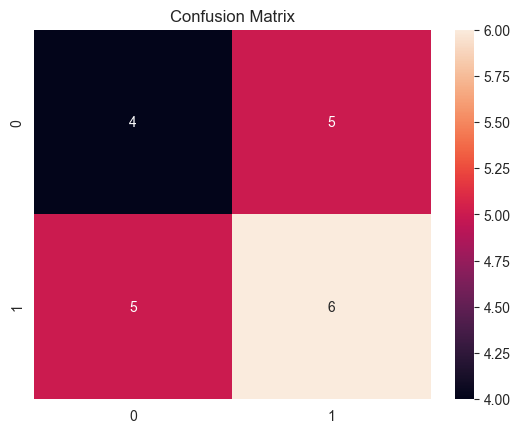

In [71]:
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d'); plt.title('Confusion Matrix'); plt.show()

Results: When the model predicts "down", it’s right 44% of the time, when it predicts "up", it’s right 73% of the time. The overall accuracy is higher than 50%, which shows better performance than random guessing. However, this model can be improved by adding more rewarded features or using alternative models.